본 코드는  GTSRB 데이터에 대하여 Adversarial Patch를 생성하는 과정과 결과를 보여준다

# Dependencies and Imports

In [24]:
# Install requirements
# %pip install

# Create a directory to store our results
# %mkdir 

In [25]:
import os
import time

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
from torchvision import models
import torchvision.datasets as dsets

import numpy as np
import csv
import matplotlib.pyplot as plt
from PIL import Image

# Display Utils

In [26]:
# Functions to show an image
def imshow(img, title):
    img = torchvision.utils.make_grid(img.cpu().data).permute(1,2,0)
    plt.imshow(img)
    plt.title(title)
    plt.show()

# Load Model and Data

In [27]:
# Load a finetuned model
PATH_TO_MODEL = "./Traffic_Sign_Classification.pth"

model = models.resnet18()
in_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(in_ftrs, 43)
model.load_state_dict(torch.load(PATH_TO_MODEL))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
# Data transformation
import torchvision.transforms as transforms
preprocess = transforms.Compose(
    [transforms.Resize([112, 112]),
    transforms.ToTensor()]
)

# Load GTSRB Data
BATCH_SIZE = 1

train_set = torchvision.datasets.ImageFolder(root="./GTSRB/Train", transform=preprocess)

# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_set) * ratio)
n_val_examples = len(train_set) - n_train_examples
gtsrb_train_data, val_data = data.random_split(train_set, [n_train_examples, n_val_examples])
train_loader = data.DataLoader(gtsrb_train_data, shuffle=True, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)

# Generate Patch

In [29]:
LR = 1.0
EPOCHS = 5
THRESHOLD=0.9
MAX_ITER=100
TARGET=35 # Go Straight Traffic Sign

# Initialize the patch
IMG_SIZE=(3, 112, 112)
NOISE_RATIO=0.2
MASK_SIZE = int((NOISE_RATIO * IMG_SIZE[1] * IMG_SIZE[2])**0.5)

patch = np.random.rand(IMG_SIZE[0], MASK_SIZE, MASK_SIZE)

Patch saved at ./Patch.png

Epoch-0: Success Rate = 98.8776 , Time = 1417.05 seconds
Epoch-1: Success Rate = 98.9413 , Time = 1415.55 seconds
Epoch-2: Success Rate = 98.9541 , Time = 1409.37 seconds
Epoch-3: Success Rate = 98.9923 , Time = 1410.80 seconds
Epoch-4: Success Rate = 98.9668 , Time = 1406.13 seconds


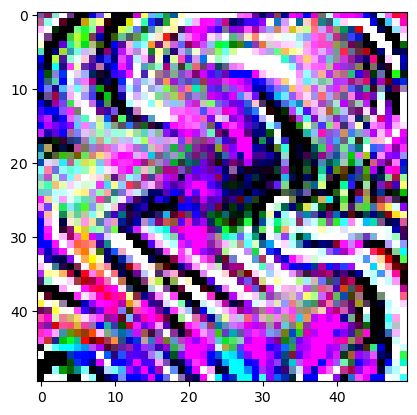

In [30]:
# Path to save Patch
PATH_TO_PATCH = "./Patch.png"
best_acc = 0.0

print("Patch saved at "+PATH_TO_PATCH)
print('')

for epoch in range(EPOCHS):
    print(f"Epoch-{epoch}: ",end='')
    start_time = time.monotonic()

    # Train the patch
    for images,labels in train_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        if preds[0] != labels[0] or preds[0].data.numpy() == TARGET: continue # only train on images that were originally classified successly
        
        # Apply the patch
        extended_patch = np.zeros(IMG_SIZE)
        x_loc, y_loc = np.random.randint(low=0, high=IMG_SIZE[1]-patch.shape[1]), np.random.randint(low=0, high=IMG_SIZE[2]-patch.shape[2]) # random patch location
        for i in range(patch.shape[0]):
            extended_patch[:, x_loc:x_loc + patch.shape[1], y_loc:y_loc + patch.shape[2]] = patch
        mask = extended_patch.copy()
        mask[mask != 0] = 1.0
        extended_patch = torch.from_numpy(extended_patch)
        mask = torch.from_numpy(mask)
        patched_images = torch.mul(mask.type(torch.FloatTensor), extended_patch.type(torch.FloatTensor)) + torch.mul((1 - mask.type(torch.FloatTensor)), images.type(torch.FloatTensor))


        # Optimize the patch
        patched_images = Variable(patched_images.data, requires_grad=True)
        output = model(patched_images)
        loss= -torch.nn.functional.log_softmax(output, dim=1)[0][TARGET]
        loss.backward()
        patch_grad = patched_images.grad.clone()
        patched_images.grad.data.zero_()
        extended_patch = extended_patch.type(torch.FloatTensor) - LR * patch_grad
        extended_patch = torch.clamp(extended_patch, min=-3, max=3)
        extended_patch = extended_patch.numpy()
        patch = extended_patch[0][:, x_loc:x_loc + patch.shape[1], y_loc:y_loc + patch.shape[2]]

        
    # Evaluate the patch
    success,total=0,0
    with torch.no_grad():
        for images,labels in val_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            # only evaluate on images that were originally classified successly
            if preds[0] != labels[0]: continue
            total+=1
             # Apply the patch
            extended_patch = np.zeros(IMG_SIZE)
            x_loc, y_loc = np.random.randint(low=0, high=IMG_SIZE[1]-patch.shape[1]), np.random.randint(low=0, high=IMG_SIZE[2]-patch.shape[2]) # random patch location
            for i in range(patch.shape[0]):
                extended_patch[:, x_loc:x_loc + patch.shape[1], y_loc:y_loc + patch.shape[2]] = patch
            mask = extended_patch.copy()
            mask[mask != 0] = 1.0
            extended_patch = torch.from_numpy(extended_patch)
            mask = torch.from_numpy(mask)
            patched_images = torch.mul(mask.type(torch.FloatTensor), extended_patch.type(torch.FloatTensor)) + torch.mul((1 - mask.type(torch.FloatTensor)), images.type(torch.FloatTensor))

            patched_outputs = model(patched_images)
            _, patched_preds = torch.max(patched_outputs, dim=1)
            if preds[0].data.numpy() != TARGET and patched_preds[0].data.numpy() == TARGET: success += 1
    end_time = time.monotonic()
    acc = 100 * success / total
    print("Success Rate = %.4f , Time = %.2f seconds" % (acc, end_time - start_time))
    if acc > best_acc:
        best_acc = acc
        plt.imshow(np.clip(np.transpose(patch, (1, 2, 0)), 0, 1))
        plt.savefig(PATH_TO_PATCH)